In [2]:
from keras.models import Sequential
import numpy as np
from keras import layers
from six.moves import range
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
import json
import matplotlib.pyplot as plt

C:\Users\s1976\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters Config

In [219]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [220]:
TRAINING_SIZE = 80000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789- '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

In [221]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [222]:
ctable = CharacterTable(chars)

In [223]:
ctable.indices_char

{0: ' ',
 1: '-',
 2: '0',
 3: '1',
 4: '2',
 5: '3',
 6: '4',
 7: '5',
 8: '6',
 9: '7',
 10: '8',
 11: '9'}

# Data Generation

In [224]:
questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b),reverse=True))
    a,b = key[0],key[1]
    if key in seen:
        continue
    seen.add(key)
    q = '{}-{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a - b)
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 80000


In [225]:
print(questions[:5], expected[:5])

['95-8   ', '37-5   ', '118-59 ', '156-28 ', '570-444'] ['87  ', '32  ', '59  ', '128 ', '126 ']


# Processing

In [226]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization...


In [227]:
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:40000]
train_y = y[:40000]
test_x = x[40000:]
test_y = y[40000:]

split_at = len(train_x) - len(train_x) // 10
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(36000, 7, 12)
(36000, 4, 12)
Validation Data:
(4000, 7, 12)
(4000, 4, 12)
Testing Data:
(40000, 7, 12)
(40000, 4, 12)


In [228]:
print("input: ", x_train[:3], '\n\n', "label: ", y_train[:3])

input:  [[[False False False False False False False False False False False
    True]
  [False False False False False  True False False False False False
   False]
  [False False False False False False False False False  True False
   False]
  [False  True False False False False False False False False False
   False]
  [False False False False False False False False False False False
    True]
  [False False False False  True False False False False False False
   False]
  [False False False False False False False False  True False False
   False]]

 [[False False False False False False False False False False False
    True]
  [False False False False  True False False False False False False
   False]
  [False  True False False False False False False False False False
   False]
  [False False False False False False False False  True False False
   False]
  [False False False False False False False  True False False False
   False]
  [ True False False False False False Fal

# Build Model

In [229]:
from keras import metrics
print('Build model...')

############################################
##### Build your own model here ############
############################################
model = Sequential()
model.add(RNN(100, input_shape=(MAXLEN, len(chars))))
model.add(RepeatVector(DIGITS+1))
model.add(RNN(80, return_sequences=True))
model.add(TimeDistributed(Dense(12, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 100)               45200     
_________________________________________________________________
repeat_vector_13 (RepeatVect (None, 4, 100)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 4, 80)             57920     
_________________________________________________________________
time_distributed_13 (TimeDis (None, 4, 12)             972       
Total params: 104,092
Trainable params: 104,092
Non-trainable params: 0
_________________________________________________________________


# Training

In [230]:
print()
print('-' * 50)
#print('Iteration', iteration)
result = model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=100,
            validation_data=(x_val, y_val))

def print_result():    
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)


--------------------------------------------------
Train on 36000 samples, validate on 4000 samples
Epoch 1/100
36000/36000 [==============================] - 9s 259us/step - loss: 1.8227 - acc: 0.3362 - val_loss: 1.7131 - val_acc: 0.3590
Epoch 2/100
36000/36000 [==============================] - 6s 179us/step - loss: 1.6763 - acc: 0.3718 - val_loss: 1.6352 - val_acc: 0.3834
Epoch 3/100
36000/36000 [==============================] - 7s 185us/step - loss: 1.5993 - acc: 0.4076 - val_loss: 1.5605 - val_acc: 0.4226
Epoch 4/100
36000/36000 [==============================] - 6s 170us/step - loss: 1.5094 - acc: 0.4440 - val_loss: 1.4753 - val_acc: 0.4552
Epoch 5/100
36000/36000 [==============================] - 6s 170us/step - loss: 1.4298 - acc: 0.4746 - val_loss: 1.4119 - val_acc: 0.4767
Epoch 6/100
36000/36000 [==============================] - 6s 168us/step - loss: 1.3618 - acc: 0.5001 - val_loss: 1.3546 - val_acc: 0.5034
Epoch 7/100
36000/36000 [==============================] - 6s 168

In [232]:
with open('DIGIT-3(sub,training_size = 36000).json','w') as f:
    json.dump(result.history,f)

# Testing

In [233]:
print("MSG : Prediction")
#####################################################
## Try to test and evaluate your model ##############
## ex. test_x = ["555+175", "860+7  ", "340+29 "]
## ex. test_y = ["730 ", "867 ", "369 "] 
#####################################################
accur = 0 
for i in range(len(test_x)):
    ind = i
    rowx, rowy = test_x[np.array([ind])], test_y[np.array([ind])]
    preds = model.predict_classes(rowx, verbose=0)
    q = ctable.decode(rowx[0])
    correct = ctable.decode(rowy[0])
    guess = ctable.decode(preds[0], calc_argmax=False)
    if i % 1000 == 0:
        print(i)
    if correct == guess:
        accur += 1
accur = accur / len(test_x)
print("Accuracy: ",accur)

MSG : Prediction
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
Accuracy:  0.9254


In [234]:
fp = open("Accuracy(sub,training_size = 36000).txt", "a")
fp.write(str(accur)+'\n')
fp.close()

# Analysis of Different Digits and Different Training Data Size
### 1.Training data size = 18000
### 2.Validation data size = 2000
### 3.Test data size = 60000

In [17]:
alll_18000 = {}
for i in range(3,6):
    with open('DIGIT-'+str(i)+'(sub,training_size = 18000).json','r') as f:
        result = json.load(f)
    alll_18000[str(i)] = result

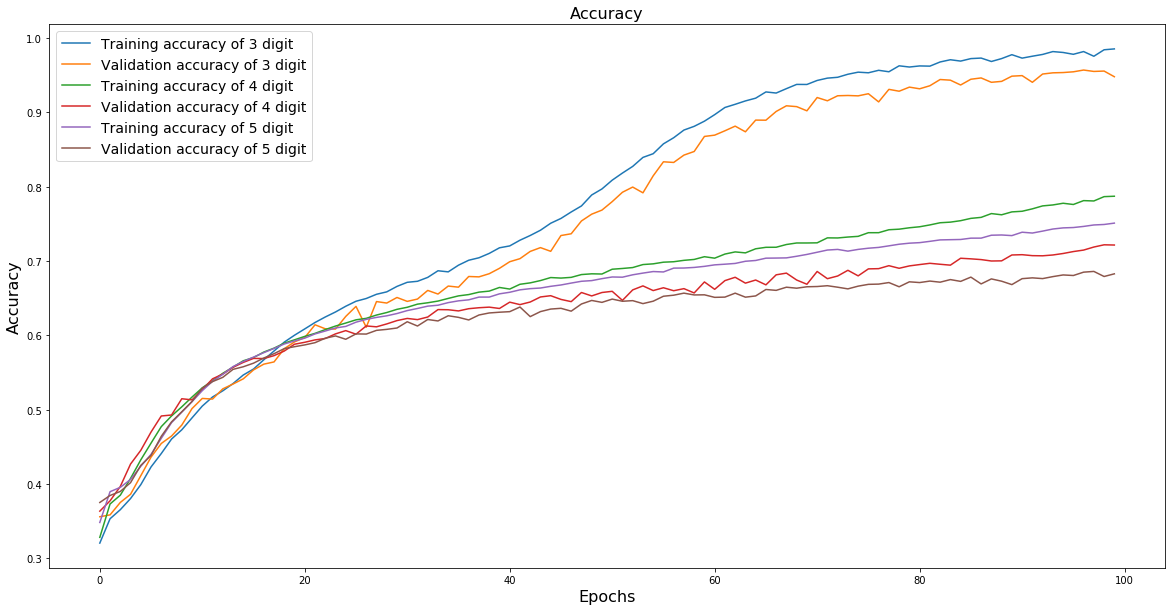

In [16]:
plt.figure(figsize=(20,10))
for i in range(3,6):
    acc = alll_18000[str(i)]['acc']
    val_acc = alll_18000[str(i)]['val_acc']
    plt.plot(acc, label='Training accuracy of %i digit' %i)
    plt.plot(val_acc, label='Validation accuracy of %i digit' %i)
plt.title('Accuracy',fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=14)
plt.show()

In [15]:
Accuracy_data = open('Accuracy(sub,training_size = 18000).txt','r')
io = Accuracy_data.readlines()
print("Test accuracy of 3 digit is ",io[0][:-1])
print("Test accuracy of 4 digit is ",io[1][:-1])
print("Test accuracy of 5 digit is ",io[2][:-1])

Test accuracy of 3 digit is  0.8580166666666666
Test accuracy of 4 digit is  0.19178333333333333
Test accuracy of 5 digit is  0.1008


## Conclusion
- 從上圖可以得知，隨著 digit 增加，validation accuracy 會下降。
- 在 digit 為 4、5 的情況下有 overfitting 的情況發生

## 1.Training data size = 36000
## 2.Validation data size = 4000
## 3.Test data size = 40000

In [12]:
alll_36000 = {}
for i in range(3,6):
    with open('DIGIT-'+str(i)+'(sub,training_size = 36000).json','r') as f:
        result = json.load(f)
    alll_36000[str(i)] = result

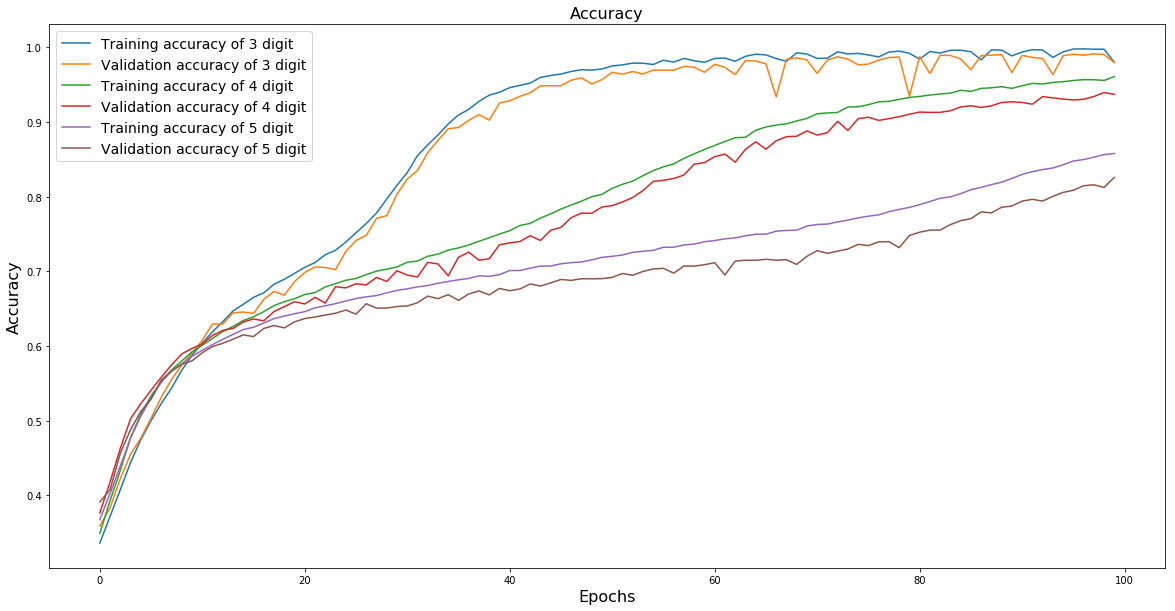

In [13]:
plt.figure(figsize=(20,10))
for i in range(3,6):
    acc = alll_36000[str(i)]['acc']
    val_acc = alll_36000[str(i)]['val_acc']
    plt.plot(acc, label='Training accuracy of %i digit' %i)
    plt.plot(val_acc, label='Validation accuracy of %i digit' %i)
plt.title('Accuracy',fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=14)
plt.show()

In [14]:
Accuracy_data = open('Accuracy(sub,training_size = 36000).txt','r')
io = Accuracy_data.readlines()
print("Test accuracy of 3 digit is ",io[0][:-1])
print("Test accuracy of 4 digit is ",io[1][:-1])
print("Test accuracy of 5 digit is ",io[2][:-1])

Test accuracy of 3 digit is  0.9254
Test accuracy of 4 digit is  0.75855
Test accuracy of 5 digit is  0.418525
